In [1]:
from typing import NamedTuple, Tuple
import os
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models import alexnet

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim
import cv2 as cv
from scipy.interpolate import RegularGridInterpolator

# Fundamental

In [2]:
mpl.rcParams['figure.dpi'] = 300
sns.set_theme()
sns.set_style("ticks")

In [6]:
def undistort(dc: np.ndarray, k: float, yx: np.ndarray) -> np.ndarray:
    r2 = ((yx - dc) ** 2).sum(axis=1, keepdims=True)
    vu = dc + (yx - dc) / (1 + k * r2)
    return vu


def redistort(
    dc: np.ndarray,  # centre point, *2
    k: float,        # distort parameter aka. lambda
    vu: np.ndarray,  # non-distorted, n * 2
) -> np.ndarray:     # n * 2

    # Extract components for clarity
    xb = vu[:, 0]
    yb = vu[:, 1]
    x0 = dc[0]
    y0 = dc[1]

    # Calculate the radial distance rc for each point
    rc = np.sqrt((xb - x0)**2 + (yb - y0)**2)

    # Ensure that rc is not zero to avoid division by zero
    rc_safe = np.where(rc == 0, 1e-8, rc)

    # Calculate the distorted coordinates using the provided formula
    factor = (1 - np.sqrt(1 - 4 * k * rc_safe**2)) / (2 * k * rc_safe**2)
    x_distorted = x0 + (xb - x0) * factor
    y_distorted = y0 + (yb - y0) * factor

    # Combine the distorted x and y into a single array
    yx = np.vstack((x_distorted, y_distorted)).T

    return yx


def setup_transform(dc: np.ndarray, k: float, mn: Tuple[int, int], scale: float):
    ylong = np.arange(0, mn[0], scale) # Generate values from 0 to mn[0]-1 with a step of "scale"
    xlong = np.arange(0, mn[1], scale)
    yxrect_d3 = np.stack(np.meshgrid(xlong, ylong), axis=-1)
    yxrect = yxrect_d3.reshape((-1, 2))[:, ::-1]

    interp_grid = tuple(dim.ravel() for dim in np.indices(dimensions=mn, sparse=True))

    return {
        'mn_high': yxrect_d3.shape[:2],
        'interp_grid': interp_grid,
        'yxdistort': redistort(dc=dc, k=k, vu=yxrect),
        'yxfixed': undistort(dc=dc, k=k, yx=yxrect),
        'rect_axes': (ylong, xlong),
    }


def distort_image(transform, image: np.ndarray) -> np.ndarray:
    distort_interp = RegularGridInterpolator(
        points=transform['interp_grid'], values=image, bounds_error=False, method='linear'
    )
    distorted = distort_interp(transform['yxdistort'])
    return distorted.reshape((*transform['mn_high'], -1))


def undistort_image(transform, image: np.ndarray) -> np.ndarray:
    undistort_interp = RegularGridInterpolator(
        points=transform['rect_axes'], values=image, bounds_error=False, method='linear'
    )
    undistorted = undistort_interp(transform['yxfixed'])
    return undistorted.reshape((*transform['mn_high'], -1))

def estimate_resolution_loss(mn: Tuple[int, int], dc: np.ndarray, k: float) -> float:
    n = 200
    middle_strip = np.empty((n, 2))
    middle_strip[:, 0] = np.linspace(0, mn[0] - 1, n) # give me n values start from 0 to mn[0] - 1
    middle_strip[:, 1] = mn[1] / 2

    distorted = redistort(dc=dc, k=k, vu=middle_strip)
    y, x = distorted.T
    y = y[np.isfinite(y)]

    res_reduce = mn[0] / (y.max() - y.min())
    return res_reduce

def roundtrip_demo(filename: str) -> None:
    imorig = np.array(Image.open(filename))
    mn = imorig.shape[:2]
    dc = 0.5 * np.array(mn) + 0.1
    k = 3e-5
    res_reduce = estimate_resolution_loss(mn=mn, dc=dc, k=k)
    transform = setup_transform(mn=mn, dc=dc, k=k, scale=res_reduce)

    imdistort = distort_image(transform, imorig / 255)
    imfixed = undistort_image(transform, imdistort)

    fig, (ax_orig, ax_distort, ax_fixed) = plt.subplots(ncols=3, figsize=(20, 10))

    ax_orig.imshow(imorig)
    ax_distort.imshow(imdistort)
    ax_fixed.imshow(imfixed)
    ax_orig.set_title('Original')
    ax_distort.set_title('Distorted')
    ax_fixed.set_title('Corrected')
    plt.show()


def distort_given_k_and_image(k: float, clean_image: np.ndarray) -> np.ndarray:

    # Calculate image dimensions and distortion center
    mn = clean_image.shape[:2]
    
    dc = 0.5 * np.array(mn) + 0.1
    
    # Estimate the resolution reduction
    res_reduce = estimate_resolution_loss(mn=mn, dc=dc, k=k)
    
    # Setup transformation
    transform = setup_transform(mn=mn, dc=dc, k=k, scale=res_reduce)
    
    # Normalize the image to range [0, 1]
    clean_image_normalised = clean_image / 255.0 if np.max(clean_image) > 1 else clean_image
    
    # Undistort the image
    distorted_image_normalised = distort_image(transform, clean_image_normalised)
    
    # Rescale the image back to [0, 255]
    distorted_image = (distorted_image_normalised * 255).astype(np.uint8)
    
    return distorted_image


def crop_largest_square_inside_round_shape(image):
    """
    Crop the image to the largest square inside the central round-shaped content,
    ensuring the square is entirely within the non-black content.
    
    Parameters:
    image (numpy.ndarray): An (n, n, 3) array representing the image.
    
    Returns:
    numpy.ndarray: The cropped image.
    """
    # Get the dimensions of the image
    n = image.shape[0]
    
    # Find the non-black pixel coordinates
    non_black_pixels = np.argwhere(image.sum(axis=-1) != 0)
    
    # Calculate the center of the bounding circle (mean of non-black pixels)
    center = non_black_pixels.mean(axis=0).astype(int)
    
    # Calculate the radius of the bounding circle (max distance from center to non-black pixel)
    distances = np.linalg.norm(non_black_pixels - center, axis=1)
    radius = int(distances.max())
    
    # Side length of the largest square that fits inside the circle
    side_length = int(np.sqrt(2) * radius)
    
    # Ensure the side_length is even
    if side_length % 2 != 0:
        side_length -= 1
    
    # Calculate the top-left corner of the square
    half_side = side_length // 2
    start_row = center[0] - half_side
    start_col = center[1] - half_side
    
    # Ensure the crop area is within the image boundaries
    start_row = max(0, start_row)
    start_col = max(0, start_col)
    end_row = min(n, start_row + side_length)
    end_col = min(n, start_col + side_length)
    
    # Crop the image
    cropped_image = image[start_row:end_row, start_col:end_col, :]
    
    return cropped_image

def undistort_given_k_and_image(mn, k: float, distorted_image: np.ndarray) -> np.ndarray:
    
    dc = 0.5 * np.array(mn) + 0.1
    
    # Estimate the resolution reduction
    res_reduce = estimate_resolution_loss(mn=mn, dc=dc, k=k)
    
    # Setup transformation
    transform = setup_transform(mn=mn, dc=dc, k=k, scale=res_reduce)
    
    # Normalize the image to range [0, 1]
    distorted_image_normalized = distorted_image / 255.0 if np.max(distorted_image) > 1 else distorted_image
    
    # Undistort the image
    undistorted_image_normalized = undistort_image(transform, distorted_image_normalized)
    
    # Rescale the image back to [0, 255]
    undistorted_image = (undistorted_image_normalized * 255).astype(np.uint8)
    
    return undistorted_image

def calculate_ssim(image1, image2):
    
    # Convert images to grayscale (SSIM is often calculated on grayscale images)
    gray_image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
    gray_image2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
    
    # Ensure the images are the same size
    if gray_image1.shape != gray_image2.shape:
        raise ValueError("Input images must have the same dimensions.")
    
    # Calculate SSIM
    ssim_index, _ = ssim(gray_image1, gray_image2, full=True)
    
    return ssim_index

def calculate_psnr(image1, image2):
    
    # Ensure the images are the same size
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions.")
    
    # Calculate MSE (Mean Squared Error)
    mse = np.mean((image1 - image2) ** 2)
    
    if mse == 0:
        return float('inf')  # Infinite PSNR if images are identical
    
    # Calculate PSNR
    max_pixel_value = 255.0
    psnr_value = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    
    return psnr_value

In [7]:
# Generate the levels and corresponding k_lower and k_upper values
levels = range(99)
k_lower = [1e-6 + i*1e-6 for i in levels]
k_upper = [2e-6 + i*1e-6 for i in levels[:-1]] + [1e-4]

# Calculate k_mean as the average of k_lower and k_upper
k_mean = [0.5 * (k_l + k_u) for k_l, k_u in zip(k_lower, k_upper)]

# Create the DataFrame
df = pd.DataFrame({
    "level": levels,
    "k_lower": k_lower,
    "k_upper": k_upper,
    "k_mean": k_mean
})

def find_level(k_value):
    """
    Function to find the level where the given k_value belongs.
    
    Parameters:
    k_value (float): The value of k to check.

    Returns:
    int: The level number where k_value belongs, or None if not found.
    """
    for idx, row in df.iterrows():
        if row['k_lower'] <= k_value <= row['k_upper']:
            return row['level']
    return None  # Return None if the k_value does not fit into any level

# Distort

In [ ]:
# Inputs

clean_image_path = 'sample_images/Clean/SamplePlatform.jpg'
model_path = 'AlexNet_cuda_weights/classreg/alexnet_classreg_epoch_22.pth'  ############# Select your trained model weights
k_gt = 1.7e-5

# Destinations

distorted_image_path = 'sample_images/Distorted/SamplePlatform.jpg'
distorted_crop_image_path = 'sample_images/DistortedCrop/SamplePlatform.jpg'
rectified_image_k_pred_path = 'sample_images/Rectified_k_pred/SamplePlatform.jpg'
rectified_image_k_gt_path = 'sample_images/Rectified_k_gt/SamplePlatform.jpg'

In [32]:
level_gt = int(find_level(k_gt))

if level_gt is not None:
    print(f"The value {k_gt} belongs to level {level_gt}.")
else:
    print(f"The value {k_gt} does not belong to any level.")

The value 1.7e-05 belongs to level 15.


/var/folders/yb/q8pvpkcj757ft6nlg4_hj5080000gn/T/ipykernel_5789/3226470629.py:26: RuntimeWarning: invalid value encountered in sqrt
  factor = (1 - np.sqrt(1 - 4 * k * rc_safe**2)) / (2 * k * rc_safe**2)
/var/folders/yb/q8pvpkcj757ft6nlg4_hj5080000gn/T/ipykernel_5789/3226470629.py:102: RuntimeWarning: invalid value encountered in cast
  distorted_image = (distorted_image_normalised * 255).astype(np.uint8)


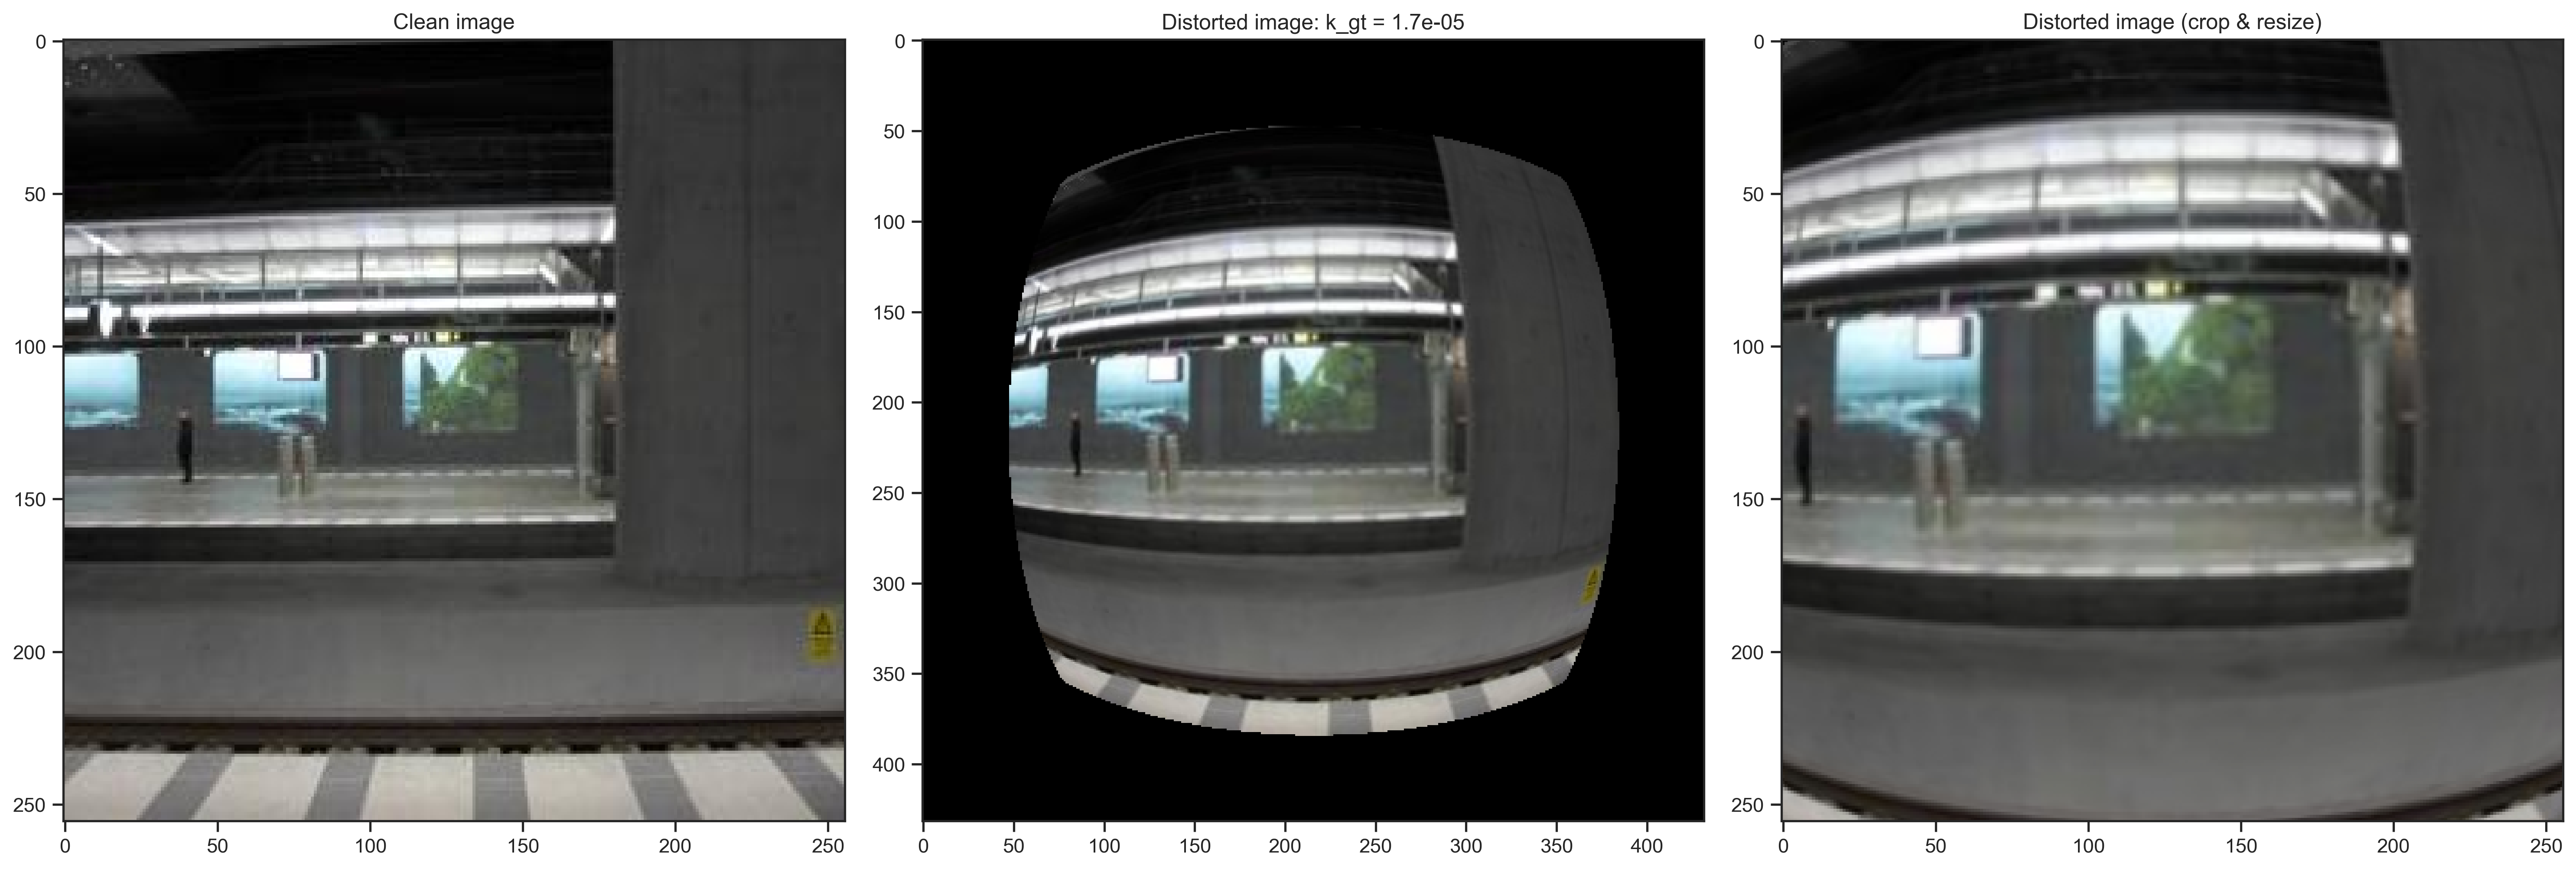

In [33]:
clean_image = np.array(Image.open(clean_image_path))
distorted_image = distort_given_k_and_image(k_gt, clean_image)
distorted_image_crop = crop_largest_square_inside_round_shape(distorted_image)
distorted_image_crop_resize = cv.resize(distorted_image_crop, (256,256))

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title("Clean image")
plt.imshow(clean_image)

plt.subplot(1, 3, 2)
plt.title(f"Distorted image: k_gt = {k_gt}")
plt.imshow(distorted_image)
cv.imwrite(distorted_image_path, cv.cvtColor(distorted_image, cv.COLOR_RGB2BGR))

plt.subplot(1, 3, 3)
plt.title("Distorted image (crop & resize)")
plt.imshow(distorted_image_crop_resize)
cv.imwrite(distorted_crop_image_path, cv.cvtColor(distorted_image_crop_resize, cv.COLOR_RGB2BGR))

plt.tight_layout()
plt.show()

# Predict k

In [35]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the pretrained AlexNet model
model = alexnet(pretrained=True)

# Modify the classifier to output 18 classes
model.classifier[-1] = nn.Linear(in_features=4096, out_features=99)

# # Load the model weights (GPU)
# model.load_state_dict(torch.load(model_path))
# model.to(device)
# model.eval()

# Load the model weights onto the CPU
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.to(device)  # Assuming `device` is set to 'cpu'
model.eval()

# Define the image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to perform inference and get probabilities
def predict_image(image_path, model, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        predicted_class = torch.argmax(probabilities, dim=1)

    return predicted_class.item(), probabilities.cpu().numpy().flatten()

Using device: cpu


In [36]:
# Perform inference
predicted_class, probabilities = predict_image(distorted_crop_image_path, model, transform, device)

# Print the predicted class and probabilities
print(f'Ground truth class: {level_gt}')
print(f'Predicted class: {predicted_class}')
print(f'Probabilities for each class: {probabilities}')

Ground truth class: 15
Predicted class: 16
Probabilities for each class: [2.84398546e-12 2.80727308e-12 1.93464602e-11 1.22287389e-10
 5.51618973e-09 5.72574987e-10 1.18968142e-08 3.39035267e-07
 3.03503884e-06 2.31442209e-05 3.39258288e-04 5.31917764e-03
 1.75090656e-02 4.65984493e-02 8.91136676e-02 1.84189647e-01
 2.40736455e-01 2.26062372e-01 1.23705417e-01 4.33064252e-02
 1.61706582e-02 5.99487592e-03 7.87321245e-04 1.17625204e-04
 9.04969147e-06 1.51791824e-06 1.25668038e-07 1.34820901e-08
 6.41620979e-09 1.86262061e-09 3.54496793e-10 1.03788117e-10
 9.33868109e-13 1.09012166e-11 2.68556358e-12 1.08557139e-11
 2.51540247e-11 2.53151649e-11 7.38622982e-11 3.62074454e-10
 8.13464585e-09 3.56014773e-09 6.88927138e-10 1.57268665e-09
 1.44486678e-09 6.79419765e-09 2.27796555e-08 2.53965027e-08
 2.92125506e-08 1.34977860e-08 3.14692450e-08 5.19642107e-09
 1.11967609e-08 4.58023308e-08 1.00544881e-07 4.26540510e-08
 4.20181578e-08 1.05551869e-07 1.38656890e-08 2.79240062e-08
 1.76916117e

In [39]:
k_pred = np.dot(probabilities, k_mean)
k_pred

1.760343806918771e-05

# Rectify using k_pred

/var/folders/yb/q8pvpkcj757ft6nlg4_hj5080000gn/T/ipykernel_5789/3226470629.py:26: RuntimeWarning: invalid value encountered in sqrt
  factor = (1 - np.sqrt(1 - 4 * k * rc_safe**2)) / (2 * k * rc_safe**2)


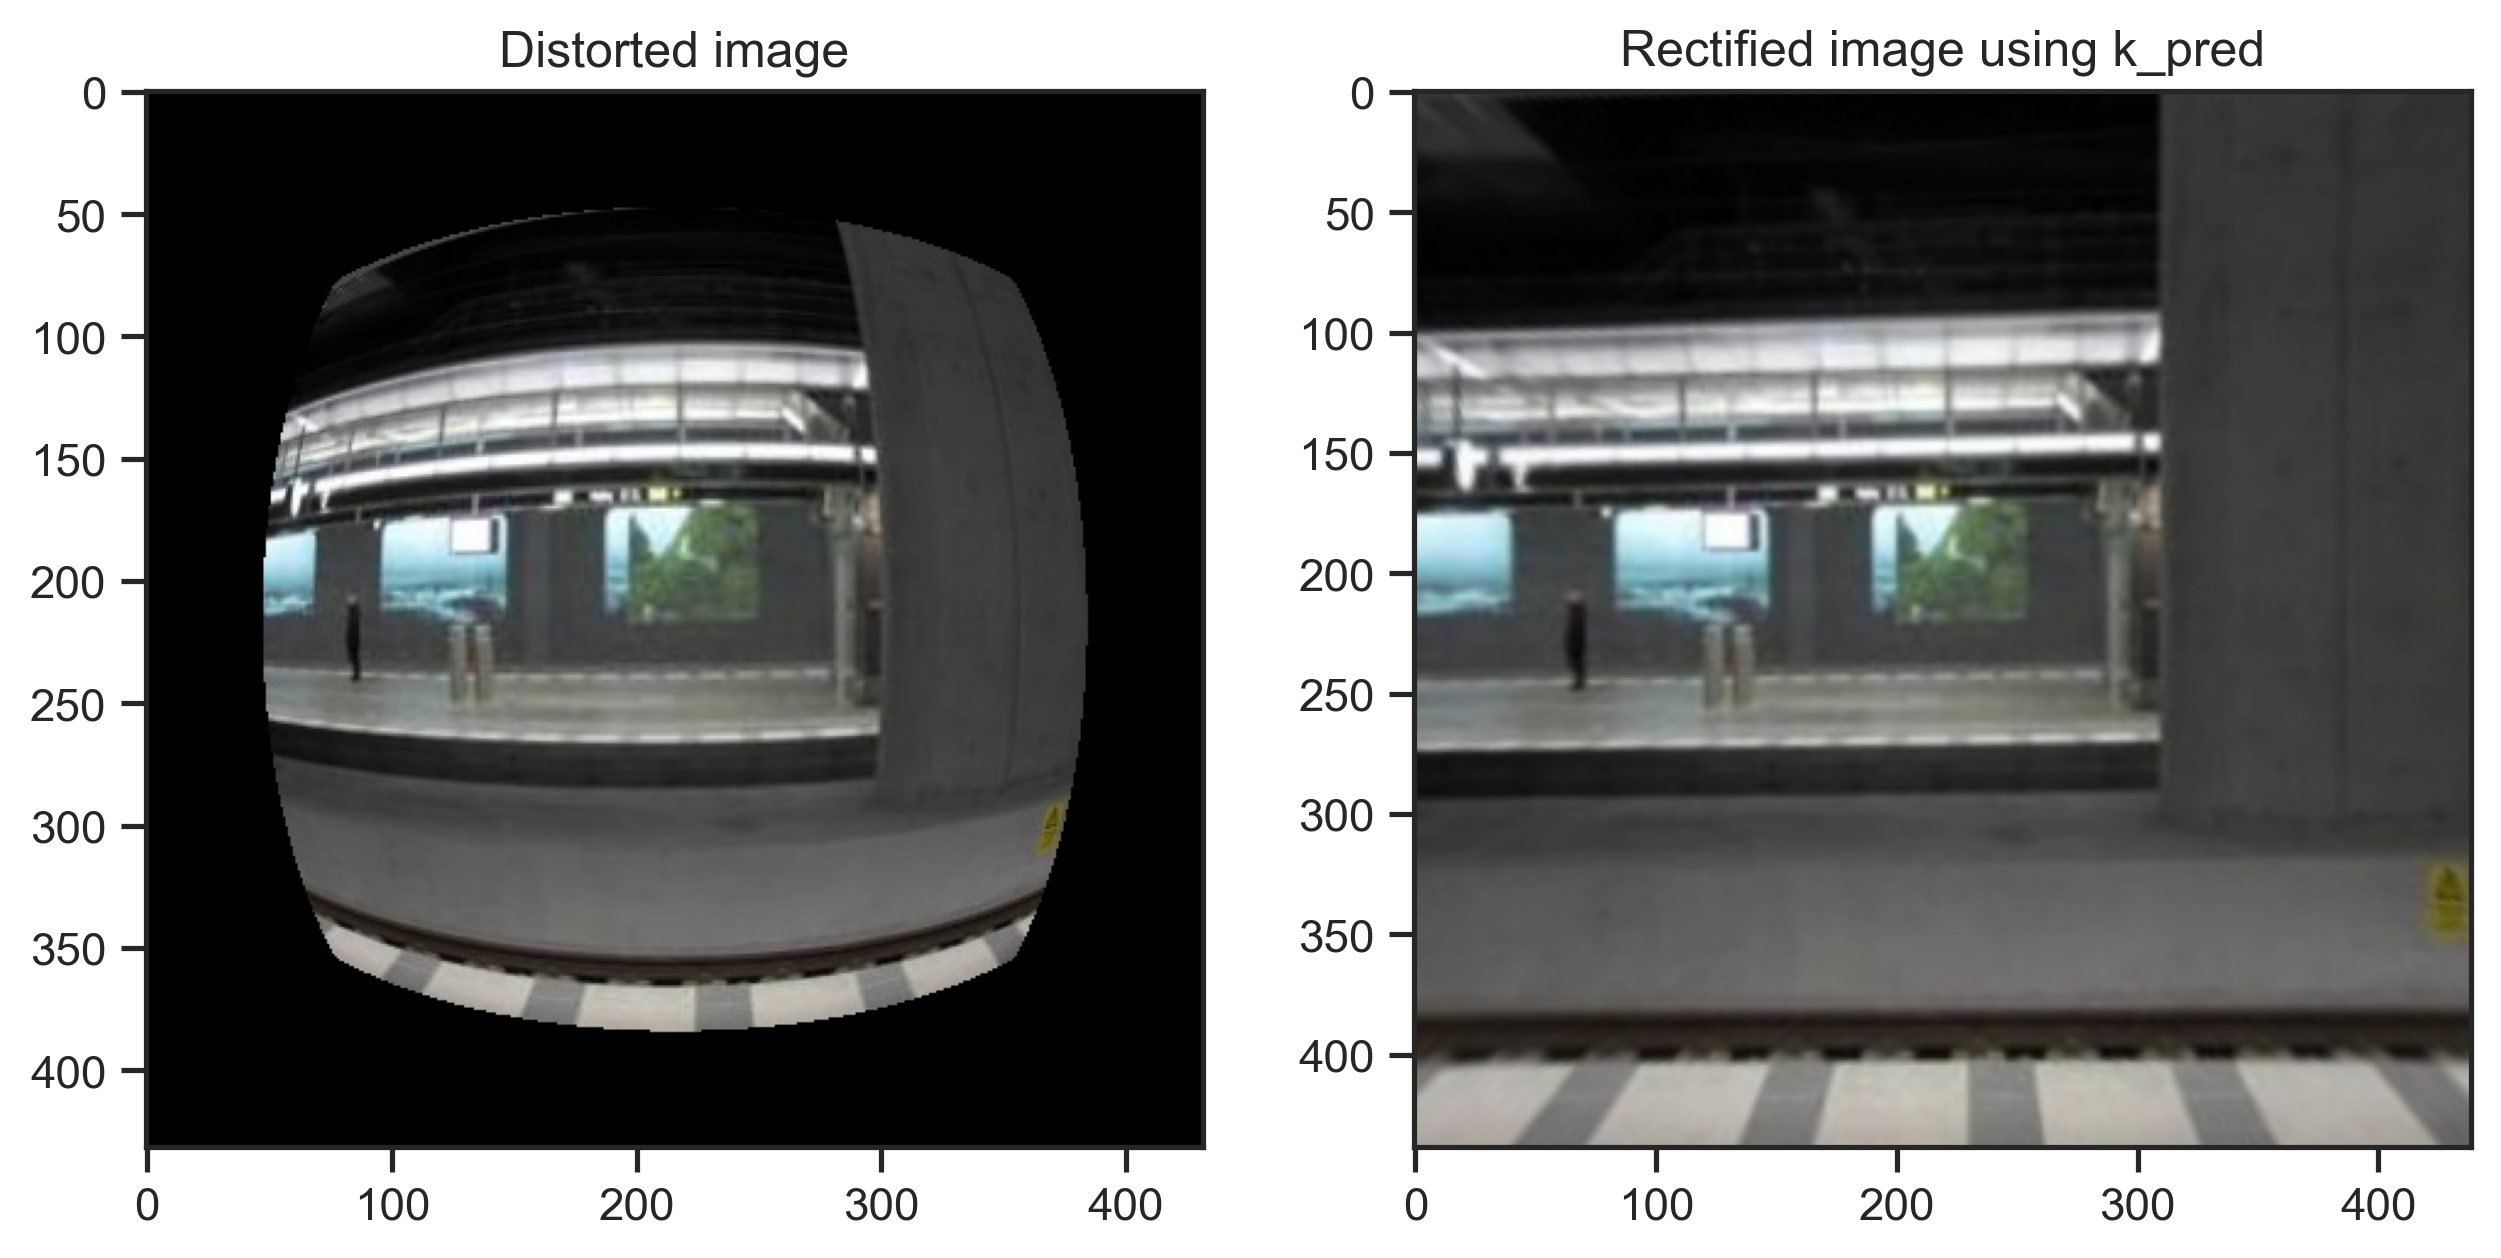

True

In [41]:
n_c = (256,256) # Assume the size of the clean image size
m = 0.5 * np.array(n_c) + 0.1 # Centre of the image
scale = estimate_resolution_loss(n_c, m, k_pred) # Steps for rescaling
distorted_image = np.array(Image.open(distorted_image_path))
n_r = int(np.ceil(n_c[0]/scale)) # Fisheye image size
distorted_image_resized = cv.resize(distorted_image, (n_r,n_r))

rectified_image = undistort_given_k_and_image(n_c, k_pred, distorted_image_resized)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Distorted image")
plt.imshow(distorted_image)

plt.subplot(1, 2, 2)
plt.title("Rectified image using k_pred")
plt.imshow(rectified_image)
plt.show()

cv.imwrite(rectified_image_k_pred_path, cv.cvtColor(rectified_image, cv.COLOR_RGB2BGR))

# Rectify using k_gt

/var/folders/yb/q8pvpkcj757ft6nlg4_hj5080000gn/T/ipykernel_5789/3226470629.py:26: RuntimeWarning: invalid value encountered in sqrt
  factor = (1 - np.sqrt(1 - 4 * k * rc_safe**2)) / (2 * k * rc_safe**2)


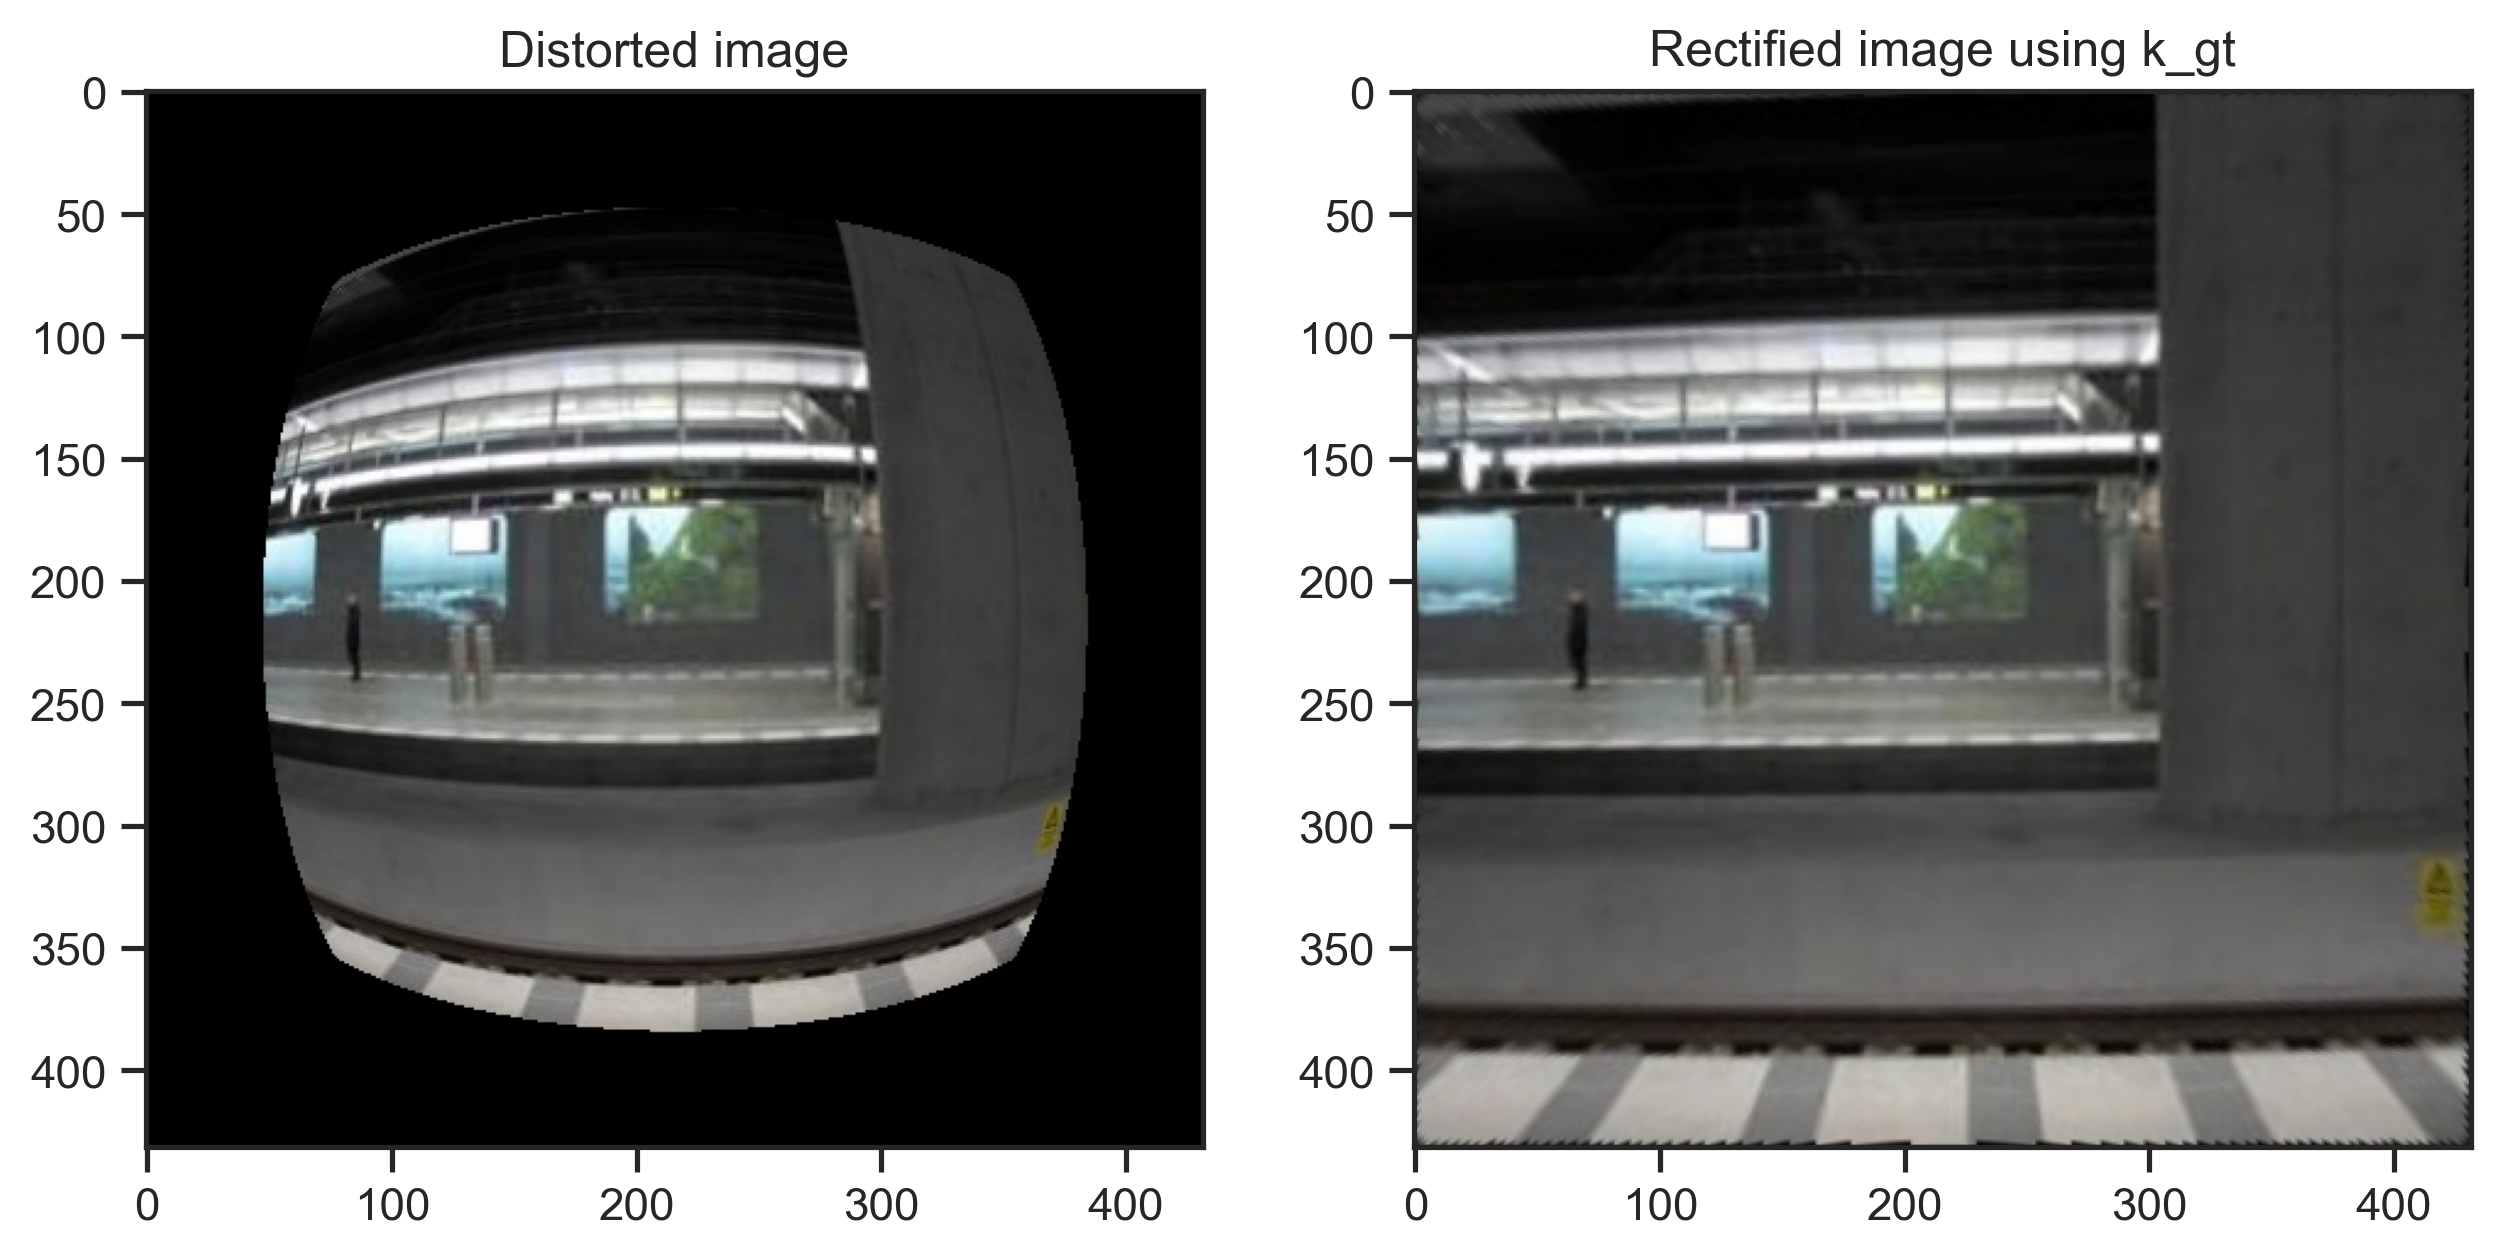

True

In [45]:
n_c = (256,256) # Assume the size of the clean image size
m = 0.5 * np.array(n_c) + 0.1 # Centre of the image
scale = estimate_resolution_loss(n_c, m, k_gt) # Steps for rescaling
distorted_image = np.array(Image.open(distorted_image_path))
n_r = int(np.ceil(n_c[0]/scale)) # Fisheye image size
distorted_image_resized = cv.resize(distorted_image, (n_r,n_r))

rectified_image = undistort_given_k_and_image(n_c, k_gt, distorted_image_resized)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Distorted image")
plt.imshow(distorted_image)

plt.subplot(1, 2, 2)
plt.title("Rectified image using k_gt")
plt.imshow(rectified_image)
plt.show()

cv.imwrite(rectified_image_k_gt_path, cv.cvtColor(rectified_image, cv.COLOR_RGB2BGR))

# Evaluate

## Average Relative Error for k_gt and k_pred

In [55]:
ARE = round(100 * abs(k_gt - k_pred) / k_gt , 2)

## SSIM and PSNR for rectified image using k_gt and rectified image using k_pred

In [51]:
# Read the images using OpenCV
clean = cv.imread(clean_image_path)
rectified_image_k_gt = cv.imread(rectified_image_k_gt_path)
rectified_image_k_pred = cv.imread(rectified_image_k_pred_path)

clean = cv.resize(clean, (256,256))
rectified_image_k_gt = cv.resize(rectified_image_k_gt, (256,256))
rectified_image_k_pred = cv.resize(rectified_image_k_pred, (256,256))

ssim_k_gt = calculate_ssim(clean, rectified_image_k_gt)
psnr_k_gt = calculate_psnr(clean, rectified_image_k_gt)

ssim_k_pred = calculate_ssim(clean, rectified_image_k_pred)
psnr_k_pred = calculate_psnr(clean, rectified_image_k_pred)

## Summary

In [57]:
print("k_gt =", k_gt)
print("k_pred =", k_pred)

print("-----------------------------------------------------------------")

print(f"SSIM for k_gt: {round(ssim_k_gt,4)}")
print(f"SSIM for k_pred: {round(ssim_k_pred,4)}")

print("-----------------------------------------------------------------")

print(f"PSNR for k_gt: {round(psnr_k_gt,4)} dB")
print(f"PSNR for k_pred: {round(psnr_k_pred,4)} dB")

print("-----------------------------------------------------------------")

print(f"Average Relative Error = {ARE}%")

k_gt = 1.7e-05
k_pred = 1.760343806918771e-05
-----------------------------------------------------------------
SSIM for k_gt: 0.9532
SSIM for k_pred: 0.8971
-----------------------------------------------------------------
PSNR for k_gt: 34.9849 dB
PSNR for k_pred: 33.7446 dB
-----------------------------------------------------------------
Average Relative Error = 3.55%
